In [351]:
import numpy as np
import scanpy as sc 
import matplotlib.pyplot as plt
import scipy.sparse as sp
import pandas as pd
import anndata

from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

# Step 1: load and filter data to reconstruct the cortex example

In [352]:
# load 
adata_full = sc.read_h5ad("source_data/total_dataset.h5ad")
adata_full.var.index = list(adata_full.var["gene_short_name"])
adata_full.var_names_make_unique()

# normalize for visualization / save raw counts
adata_full.layers["counts"] = adata_full.X.copy()
sc.pp.normalize_total(adata_full, target_sum=1e4)
sc.pp.log1p(adata_full)
adata_full.raw = adata_full

# prepare loc w. jitter and w/
adata_full.obsm["loc"] = np.vstack((adata_full.obs["coords.x1"], adata_full.obs["coords.x2"])).T
adata_full.obsm["jloc"] = adata_full.obsm["loc"] +  5 * np.random.normal(size=(adata_full.n_obs, 2))
adata_full.obsm["gridloc"] = np.vstack((adata_full.obs["Row"], adata_full.obs["Col"])).T
# most space wasting onto mapping of your life
adata_full.obs["RtC"] = adata_full.obs["Row"] * adata_full.obs["Col"] * adata_full.obs["slide_id"].apply(lambda x: int(x[-2:])).astype("int")

In [353]:
# select slices according to paper
slice_selected_list = ["Slide 8", "Slide 9", "Slide 11", "Slide 13", "Slide 14"]
adata_full = adata_full[np.where([x in slice_selected_list for x in adata_full.obs["slide_id"]])[0]].copy()

# select anatomical region
adata = adata_full[adata_full.obs["anatomical_annotation"] == "Cortex"].copy()

/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [354]:
adata.obs["final_cluster_label"].value_counts()

Neuron                           8186
Radial glia                      1610
Connective Tissue Progenitors     581
Endothelial Cells                 507
Fibroblast                        462
Glial Cells                       204
Choroid Plexus                    129
Epithelial Cells                  121
White Blood Cells                 107
Chondrocytes                      104
Erythroid Lineage                  60
Peripheral Neuron                  50
Myocytes                           49
Schwann Cells                      25
Hepatocytes                        24
Lateral Plate Mesoderm             18
Cardiac muscle lineages            18
Developing Gut                     17
OPCs                                5
Testis Cells                        3
Name: final_cluster_label, dtype: int64

In [355]:
for name, group in adata.obs.groupby(by="slide_id")["final_cluster_label"]:
    print(name)
    print(group.value_counts())

Slide 8
Neuron                           1412
Radial glia                       152
Endothelial Cells                  89
Fibroblast                         38
Glial Cells                        33
Connective Tissue Progenitors      15
White Blood Cells                   7
Epithelial Cells                    7
Peripheral Neuron                   6
Choroid Plexus                      5
Cardiac muscle lineages             4
Lateral Plate Mesoderm              3
Myocytes                            3
Chondrocytes                        3
Schwann Cells                       3
Hepatocytes                         2
Erythroid Lineage                   1
OPCs                                0
Developing Gut                      0
Testis Cells                        0
Name: final_cluster_label, dtype: int64
Slide 9
Neuron                           1085
Radial glia                       205
Fibroblast                         81
Connective Tissue Progenitors      55
Endothelial Cells               

In [356]:
# keep only frequent cell types
# celltype_selected_list = ["Neuron", "Radial glia", "Endothelial Cells", 
#                           "Connective Tissue Progenitors", "Glial Cells", "Fibroblast"]
celltype_selected_list = ["Neuron", "Radial glia", "Endothelial Cells", 
                          "Connective Tissue Progenitors"]
print(celltype_selected_list)
adata = adata[np.where([x in celltype_selected_list for x in adata.obs["final_cluster_label"]])[0]].copy()

['Neuron', 'Radial glia', 'Endothelial Cells', 'Connective Tissue Progenitors']


In [357]:
np.unique(adata.obs["RtC"]).shape[0], adata.n_obs

(776, 10884)

Trying to set attribute `.uns` of view, copying.


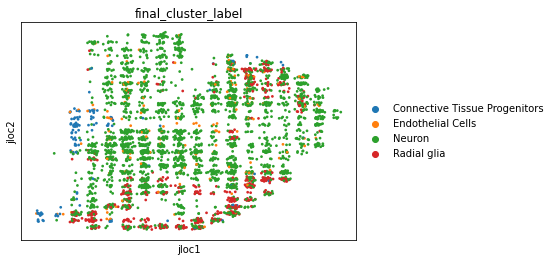

In [358]:
subset = adata[np.where(adata.obs["slide_id"] == "Slide 14")[0]]
sc.pl.embedding(subset, "jloc", color="final_cluster_label")

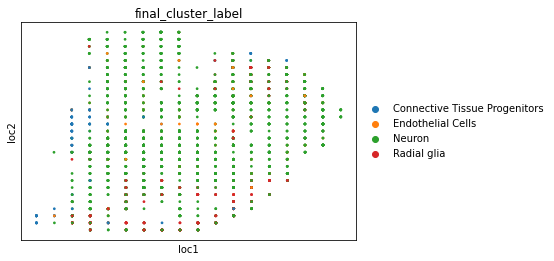

In [359]:
sc.pl.embedding(subset, "loc", color="final_cluster_label")

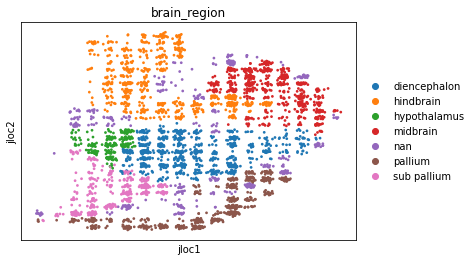

In [360]:
sc.pl.embedding(subset, "jloc", color="brain_region")

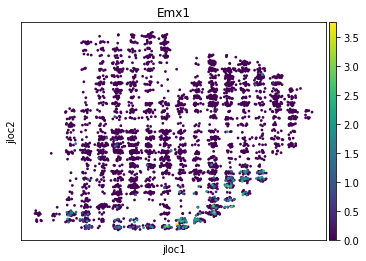

In [361]:
sc.pl.embedding(subset, "jloc", color="Emx1")

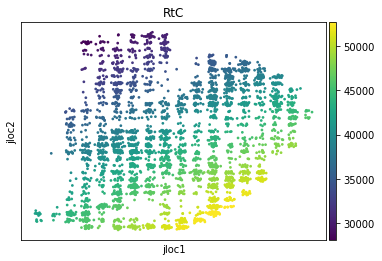

In [362]:
sc.pl.embedding(subset, "jloc", color="RtC")

# Step 2: Put together the scRNA-seq data

In [363]:
# check for batch effects between slides, run PCA
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=4000,
    subset=True, # to automatically subset to the 4000 genes
    layer="counts",
    flavor="seurat_v3"
)

/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[: int(n_top_genes), 'highly_variable'] = True


In [364]:
adata.obs["cell_type"] = pd.Series(data=pd.factorize(adata.obs["final_cluster_label"])[0], index=adata.obs.index)
adata.uns["cell_type_name"] = list(pd.factorize(adata.obs["final_cluster_label"])[1])

In [365]:
adata.uns["cell_type_name"]

['Neuron', 'Connective Tissue Progenitors', 'Radial glia', 'Endothelial Cells']

In [366]:
sc.tl.pca(adata, n_comps=30)
sc.pp.neighbors(adata, metric="cosine")
sc.tl.umap(adata)

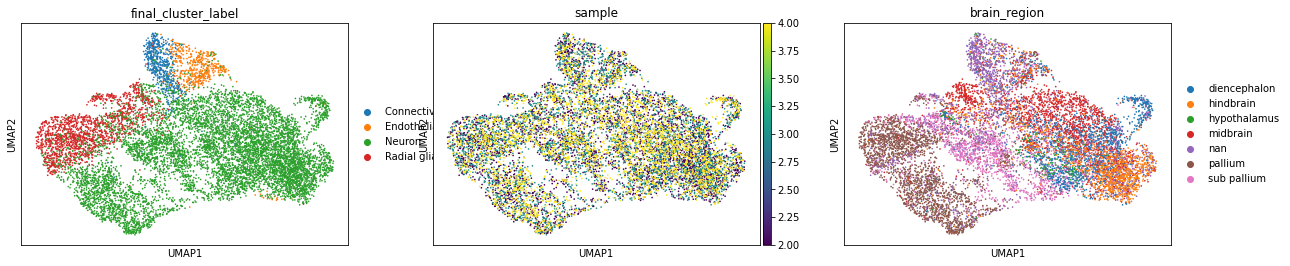

In [367]:
sc.pl.umap(adata, color=["final_cluster_label", "sample", "brain_region"])

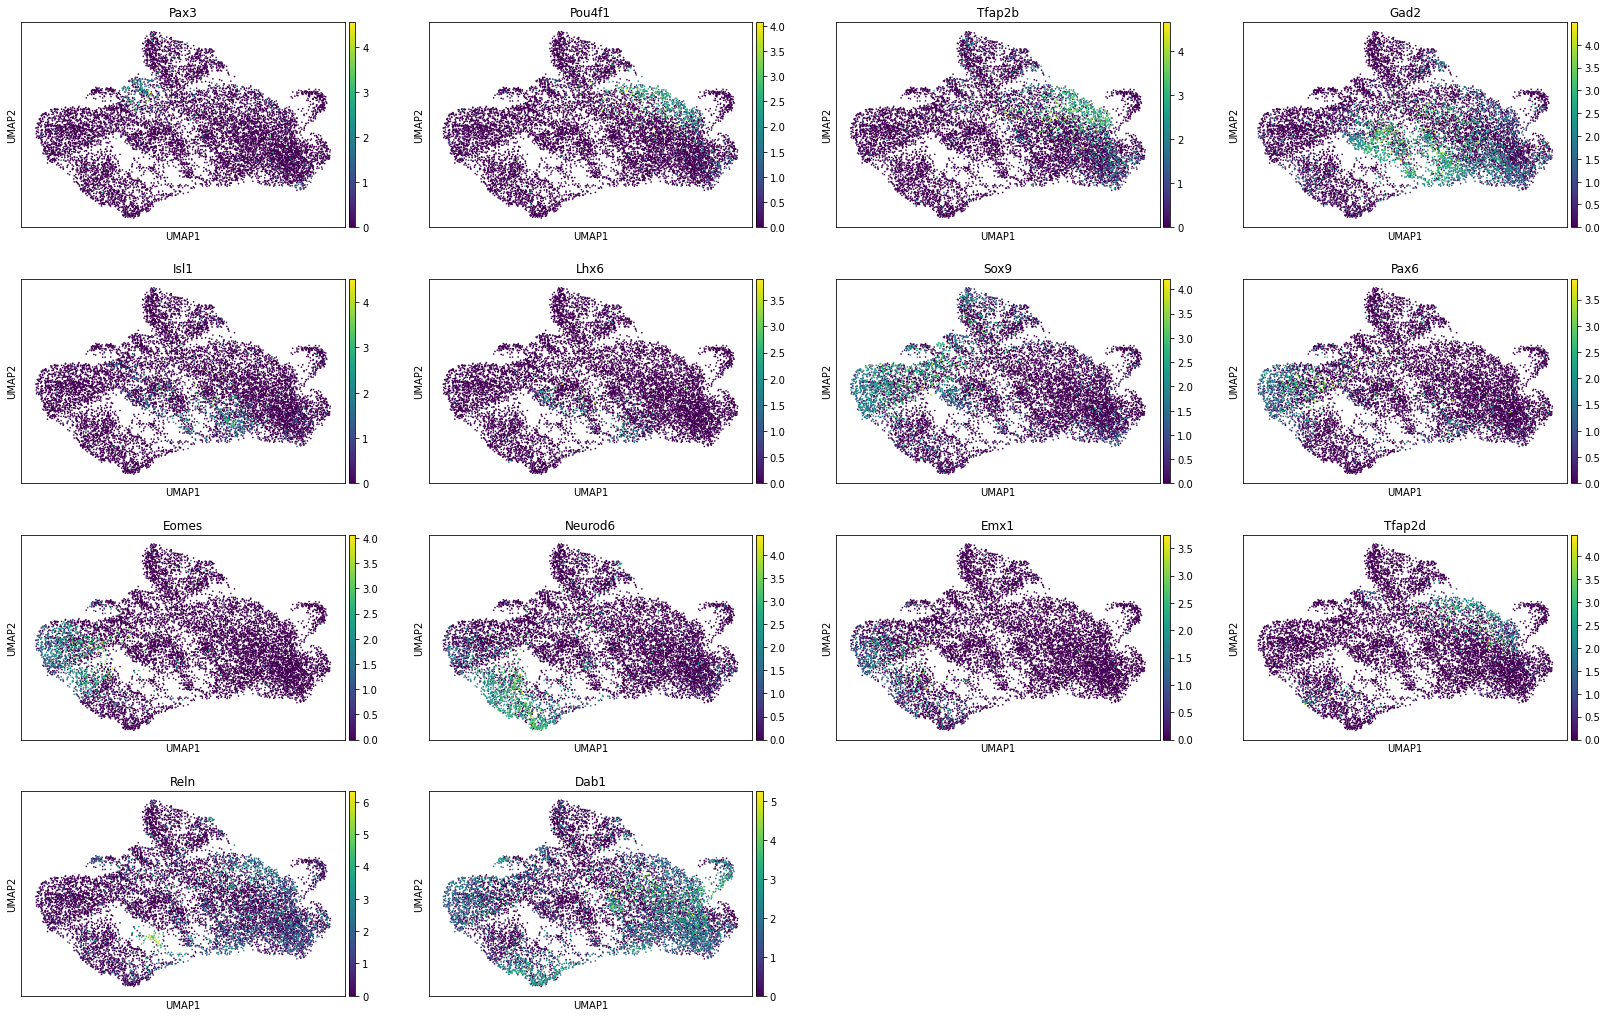

In [368]:
sc.pl.umap(adata, color=["Pax3", "Pou4f1", "Tfap2b", "Gad2", "Isl1", "Lhx6", "Sox9", 
                  "Pax6", "Eomes", "Neurod6", "Emx1", "Tfap2d", "Reln", "Dab1"])

In [369]:
# cluster the single-cell data using sklearn
target_list = [2, 4, 8]
key_list = ["cell_type"]
hier_labels_sc = np.zeros((adata.n_obs, len(target_list)))
for ct in range(4):
    slice_ind = np.where(adata.obs["cell_type"] == ct)
    slice_embedding = adata.obsm["X_pca"][slice_ind]
    knn_graph = kneighbors_graph(slice_embedding, 30, include_self=False)
    for i, target in enumerate(target_list):
        labels = AgglomerativeClustering(n_clusters=target, connectivity=knn_graph).fit_predict(slice_embedding)
        hier_labels_sc[slice_ind, i] = labels

In [370]:
# aggregate hierarchical labels and append to anndata
for i, target in enumerate(target_list):
    base_cell_type = adata.obs["cell_type"]
    sub_cell_type = hier_labels_sc[:, i]
    nb_sub_ct = len(np.unique(sub_cell_type))
    all_cell_type = np.array([base_cell_type[j] * nb_sub_ct + sub_cell_type[j] for j in range(adata.n_obs)])
    key = str(target) + "th_sub-cell_type"
    adata.obs[key] = all_cell_type.astype(np.int)
    key_list.append(key)
# dump keys as well
adata.uns["key_clustering"] = key_list
adata.uns["target_list"] = [1] + target_list

In [371]:
# restore count layer
adata.X = adata.layers["counts"]
adata.obsm["locations"] = adata.obsm["jloc"]
adata.obs["n_counts"] = np.sum(adata.X.A, axis=1)
# save to disk 
adata.write_h5ad("benchmarking_data/sc_simu.h5ad", compression="gzip")

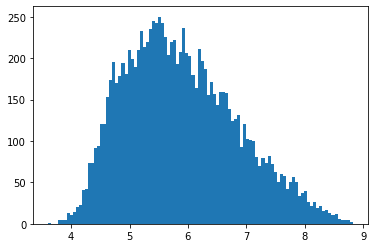

In [404]:
plt.hist(np.log(1 + adata.obs["n_counts"]), bins=100)
plt.show()

# Step 3: Assemble the spatial dataset

In [440]:
# find the spots
rct_index = np.unique(adata.obs["RtC"])
n_spots = rct_index.shape[0]
n_genes = adata.n_vars
n_ct = len(celltype_selected_list)

# pick interesting genes
# neurons specific
interest_genes = ["Pax3", "Pou4f1", "Tfap2b", "Gad2", "Isl1", "Lhx6", "Sox9", 
                  "Pax6", "Eomes", "Neurod6", "Tfap2d", "Reln", "Dab1"]
n_int_genes = len(interest_genes)
#, "Crmp1", "Dcx"] last two are not highly variables
sc_gene_expression = adata[:, interest_genes].layers["counts"].A

/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [453]:
# aggregate counts and add the groundtruth in the object for ease of benchmarking
subsampling = 0.1
# we will have two arrays. First one with real data, other with reweighted data
spatial_data = np.zeros(shape=(2 * n_spots, n_genes))
groundtruth_neurons = np.zeros(shape=(2 * n_spots, n_int_genes))
groundtruth_rglia = np.zeros(shape=(2 * n_spots, n_int_genes))
locations = np.zeros(shape=(2 * n_spots, 2))
n_cells = np.zeros(shape=(2 * n_spots,))
proportions = np.zeros(shape=(2 * n_spots, n_ct))
special_filter = np.ones(shape=(2 * n_spots))
# well suboptimal, but will do for once
for spot in range(n_spots):
    # get cells associated with spot
    mapping = np.where(adata.obs["RtC"] == rct_index[spot])[0]
    locations[spot] = adata.obsm["locations"][mapping][0]
    n_cells[spot] = len(mapping)
    # get proportion
    ct_sums = adata.obs["final_cluster_label"][mapping].value_counts()[celltype_selected_list].values
    proportions[spot] = ct_sums / np.sum(ct_sums)
    # aggregate counts
    counts = np.sum(adata.layers["counts"][mapping].A, axis=0).astype(np.int)
    # subsample
    spatial_data[spot] = np.random.binomial(counts, subsampling)
    # get counts for neurons
    where_neurons = np.where(adata.obs["final_cluster_label"][mapping] == "Neuron")[0]
    if len(where_neurons) > 0:
        groundtruth_neurons[spot] = np.mean(sc_gene_expression[mapping][where_neurons], axis=0)
    # get counts for radial_glia    
    where_rglia = np.where(adata.obs["final_cluster_label"][mapping] == "Radial glia")[0]
    if len(where_rglia) > 0:
        groundtruth_rglia[spot] = np.mean(sc_gene_expression[mapping][where_rglia], axis=0)
        
# copy most information to the second slice
groundtruth_neurons[n_spots:] = groundtruth_neurons[:n_spots]
groundtruth_rglia[n_spots:] = groundtruth_rglia[:n_spots]
locations[n_spots:] = locations[:n_spots]
rct_index_1 = [x + np.max(rct_index) for x in rct_index]
rct_index_all = np.hstack([rct_index, rct_index_1])

In [455]:
inflation = 5
# now missing proportions and recombined counts with inflated proportions
for spot in range(n_spots):
    mapping = np.where(adata.obs["RtC"] == rct_index[spot])[0]
    ct_sums = adata.obs["final_cluster_label"][mapping].value_counts()[celltype_selected_list].values
    ct_sums[1:] *= inflation
    proportions[n_spots + spot] = ct_sums / np.sum(ct_sums)
    if proportions[n_spots + spot][0] == 1:
        special_filter[n_spots + spot] = 0
    for cell in mapping:
        mult = inflation if adata.obs["cell_type"][cell] > 0 else 1
        spatial_data[n_spots + spot] += mult * adata.layers["counts"][cell].A[0]
        n_cells[n_spots + spot] += mult
    spatial_data[n_spots + spot] = np.random.binomial(spatial_data[n_spots + spot].astype(np.int), subsampling)

In [456]:
spatial_data = sp.csr_matrix(spatial_data)

spatial_adata = anndata.AnnData(spatial_data, pd.DataFrame(data=rct_index_all, columns=['RcT']), adata.var)
spatial_adata.obsm["proportions"] = pd.DataFrame(data=proportions, 
                                                 index=spatial_adata.obs.index, columns=celltype_selected_list)
spatial_adata.obsm["Neuron"] = pd.DataFrame(data=groundtruth_neurons, 
                                                 index=spatial_adata.obs.index, columns=interest_genes)
spatial_adata.obsm["Radial glia"] = pd.DataFrame(data=groundtruth_rglia, 
                                                 index=spatial_adata.obs.index, columns=interest_genes)
spatial_adata.obsm["locations"] = pd.DataFrame(data=locations, 
                                                 index=spatial_adata.obs.index, columns=["X", "Y"])
spatial_adata.obs["n_cells"] = pd.DataFrame(data=n_cells, 
                                                 index=spatial_adata.obs.index)
spatial_adata.obs["n_counts"] = np.sum(spatial_adata.X.A, axis=1)
spatial_adata.uns["interest_genes"] = interest_genes

/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [457]:
spatial_adata = spatial_adata[special_filter == 1].copy()

/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [458]:
spatial_adata.obs

,RcT,n_cells,n_counts
0,2728,7.0,268.0
1,2750,1.0,58.0
2,2816,8.0,423.0
3,2871,5.0,215.0
4,2904,8.0,275.0
...,...,...,...
1547,104636,35.0,1401.0
1548,104832,100.0,5135.0
1549,105028,69.0,3913.0
1550,105196,128.0,6047.0


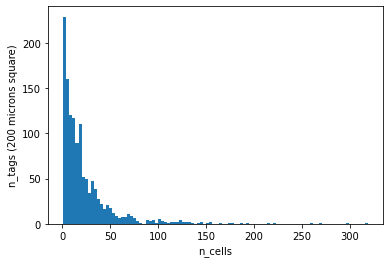

In [459]:
plt.hist(spatial_adata.obs["n_cells"], bins=100)
plt.xlabel("n_cells")
plt.ylabel("n_tags (200 microns square)")
plt.show()

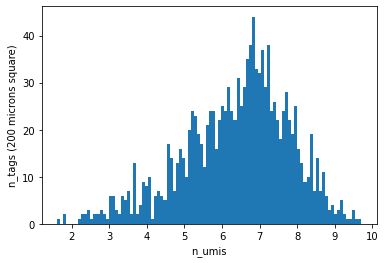

In [460]:
plt.hist(np.log(1 + spatial_adata.obs["n_counts"]), bins=100)
plt.xlabel("n_umis")
plt.ylabel("n_tags (200 microns square)")
plt.show()

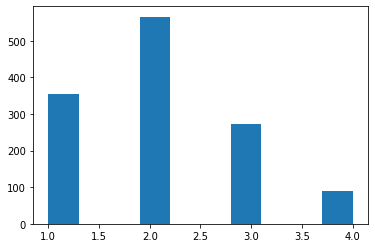

In [461]:
# cell type proportions
plt.hist(np.sum(spatial_adata.obsm["proportions"] > 0, axis=1))
plt.show()

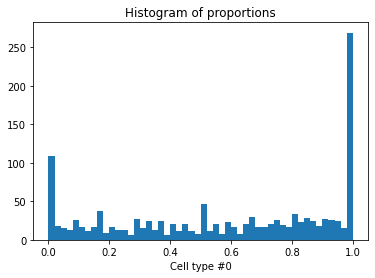

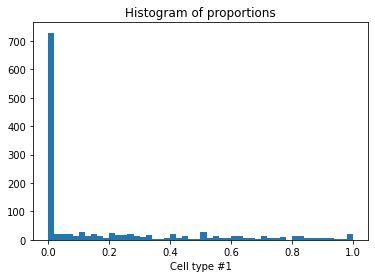

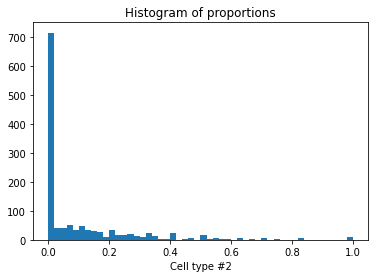

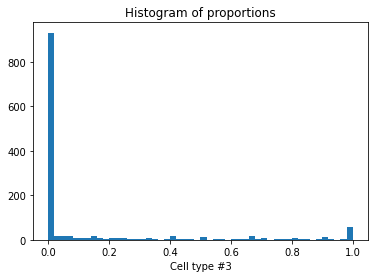

In [462]:
# cell type proportions
for i in range(4):
    plt.hist(spatial_adata.obsm["proportions"].values[:, i], bins=50)
    plt.xlabel("Cell type #" + str(i))
    plt.title("Histogram of proportions")
    plt.show()

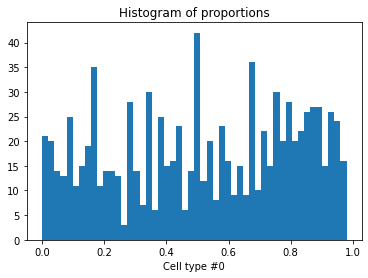

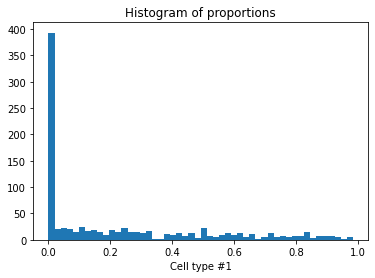

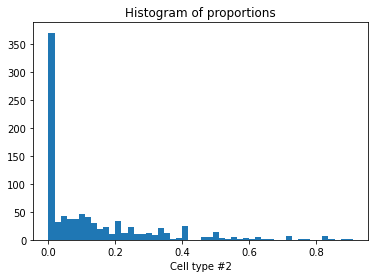

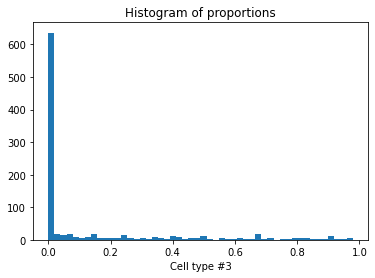

In [463]:
mask = np.sum(spatial_adata.obsm["proportions"].values > 0, axis=1) > 1
# cell type proportions for mask
for i in range(4):
    plt.hist(spatial_adata.obsm["proportions"].values[mask][:, i], bins=50)
    plt.xlabel("Cell type #" + str(i))
    plt.title("Histogram of proportions")
    plt.show()

In [464]:
# save to disk
spatial_adata.write_h5ad("benchmarking_data/st_simu.h5ad", compression="gzip")

###### explore other organs?


In [465]:
adata_full.obs["anatomical_annotation"].value_counts()

Unannotated    38970
Cortex         12280
Liver           6190
NeuralTube      1291
Heart           1194
Lung            1192
Name: anatomical_annotation, dtype: int64

In [466]:
adata_other = adata_full[adata_full.obs["anatomical_annotation"] == "Liver"].copy()

/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [467]:
adata_other.obs["final_cluster_label"].value_counts()

Erythroid Lineage                2542
Hepatocytes                      1425
Connective Tissue Progenitors     742
Lateral Plate Mesoderm            438
White Blood Cells                 258
Epithelial Cells                  191
Myocytes                          146
Endothelial Cells                 116
Chondrocytes                       86
Developing Gut                     67
Neuron                             56
Schwann Cells                      40
Peripheral Neuron                  38
Radial glia                        17
Cardiac muscle lineages            16
Testis Cells                        5
Fibroblast                          4
Choroid Plexus                      2
Glial Cells                         1
Name: final_cluster_label, dtype: int64

In [468]:
celltype_selected_list = ["Erythroid Lineage", "Hepatocytes", "Endothelial Cells", 
                          "Lateral Plate Mesoderm"]
print(celltype_selected_list)
adata_other = adata_other[np.where([x in celltype_selected_list for x in adata_other.obs["final_cluster_label"]])[0]].copy()

['Erythroid Lineage', 'Hepatocytes', 'Endothelial Cells', 'Lateral Plate Mesoderm']


Trying to set attribute `.uns` of view, copying.


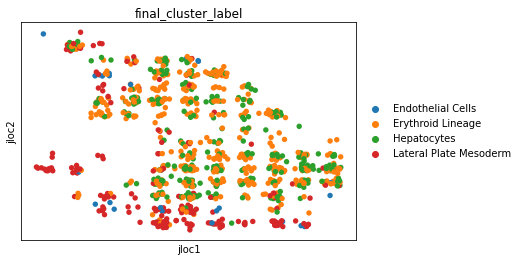

In [122]:
subset = adata_other[np.where(adata_other.obs["slide_id"] == "Slide 14")[0]]
sc.pl.embedding(subset, "jloc", color="final_cluster_label")

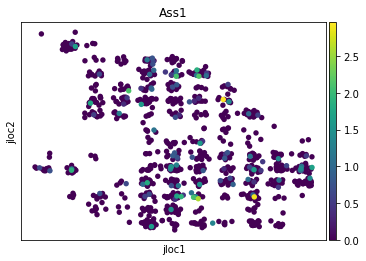

In [139]:
sc.pl.embedding(subset, "jloc", color="Ass1")